# Project Overview

In this project, we aim to simulate how we would apply machine learning in the real world and its associated challenges. In particular, how can we measure and improve the accuracy of models over its lifecycle, which is crucial for making accurate predictions on attributes that naturally evolve over time, such as housing prices. 

Moreover, we will compare the performance of our manually-trained models to that of Auto ML models. This is of particular interest to us given the prevelance of Auto ML models in the market today and their positioning as simpler alternatives to manual models.

In this notebook, we will be analyzing ~30 years of data from the Singapore HDB (public housing) resale market. Due to the non-stationary nature of the housing market, we expect the accuracy of our model to decrease over time. For example, if we train the model using data from the 1990’s, its prediction accuracy will likely be high for resale prices in the 2000’s, but lower for that of the 2010’s. To counteract this, we will re-train the model with data from the 2000’s, with the hope of making more accurate predictions on resale prices in the 2010’s.

Furthermore, we will also experiment with Auto ML models built on Redshift ML. We will follow the same training procedure and then evaluate the prediction accuracy of the manually-trained vs Redshift ML models.

# Preliminary Setup

First, let's setup the required libraries and packages such as pandas, numpy, seaborn, etc.



In [ ]:
!pip install prince

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.6/414.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
# install required libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from itertools import product
from collections import Counter
import gdown
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from prince import CA

Next, we download a copy of the Kaggle dataset containing historical Singapore HDB prices, which is stored in a Google Drive folder.

In [ ]:
raw_dataset_url = "https://drive.google.com/file/d/17_6Qzcc1xh9arYA6-Ot_O5Cai1SwN1Fx/view?usp=share_link"
raw_dataset = "raw_data.csv"
output = gdown.download(url=raw_dataset_url, output=raw_dataset, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=17_6Qzcc1xh9arYA6-Ot_O5Cai1SwN1Fx
To: /content/raw_data.csv
100%|██████████| 246M/246M [00:04<00:00, 49.9MB/s]


Then, we import the raw dataset into a dataframe called `df_raw_data` and preview the first 5 rows to verify that the dataframe was loaded successfully.

In [ ]:
df_raw_data = pd.read_csv(raw_dataset)
df_raw_data.head()

,month,year,town,town_dummy,flat_type,block,street_name,address,latitude,longitude,...,price_psm_yearly,Core CPI,price cpi_adj,price_psm cpi_adj,bala lease pct,price lease_adj implied,price_psm lease_adj implied,price cpi_lease_adj implied,price_psm cpi_lease_adj implied,year_gni
0,1990-01,1990,ANG MO KIO,2,4 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,10.997442,61.59,139633.05730,1517.750623,92.9,88869.752422,965.975570,144292.502700,1568.396769,22901
1,1990-01,1990,ANG MO KIO,2,3 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.464849,61.59,95794.77188,1168.228925,92.9,60968.783638,743.521752,98991.368143,1207.211806,22901
2,1990-01,1990,ANG MO KIO,2,3 ROOM,216,ANG MO KIO AVE 1,216 ANG MO KIO AVE 1 SINGAPORE,1.366272,103.841465,...,7.606769,61.59,76635.81750,1049.805719,92.9,48775.026911,668.151054,79193.094510,1084.836911,22901
3,1990-01,1990,ANG MO KIO,2,3 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.287972,61.59,76635.81750,1143.818172,92.9,48775.026911,727.985476,79193.094510,1181.986486,22901
4,1990-01,1990,ANG MO KIO,2,4 ROOM,211,ANG MO KIO AVE 3,211 ANG MO KIO AVE 3 SINGAPORE,1.369226,103.841652,...,11.484353,61.59,129891.21610,1603.595261,93.3,82315.112540,1016.235957,133650.125891,1650.001555,22901


# Data Cleaning

Now that the raw data has been imported into the `df_raw_data` dataframe, we can begin our exploratory data analysis! 

We start by printing a **summary of the dataframe**. 

Observe that there are 28 columns and over 800k rows. The `Non-Null Count` for every column matches the total number of rows, indicating that there are no `NULL` values in any of the columns. Furthermore, each column's datatype is displayed under `DType`.

In [ ]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840918 entries, 0 to 840917
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   month                            840918 non-null  object 
 1   year                             840918 non-null  int64  
 2   town                             840918 non-null  object 
 3   town_dummy                       840918 non-null  int64  
 4   flat_type                        840918 non-null  object 
 5   block                            840918 non-null  object 
 6   street_name                      840918 non-null  object 
 7   address                          840918 non-null  object 
 8   latitude                         840918 non-null  float64
 9   longitude                        840918 non-null  float64
 10  storey_range                     840918 non-null  object 
 11  storey                           840918 non-null  int64  
 12  ar

Notice that in the preview above, the `month` column displays both year and month, whereas it should only display the month value as an integer. 

First, we create a copy of the dataframe and name it `df_clean_data`. Then, we format the column name, modify the values in the column to drop the year and then cast the column to an integer type. Finally, we preview the first 5 rows of the modified `month` column to verify the changes.

In [ ]:
df_clean_data = df_raw_data.copy()
df_clean_data = df_clean_data.rename(columns=lambda x: x.lower().replace(' ', '_'))
df_clean_data['town'] = df_clean_data['town'].str.lower().str.replace(' ', '_')
df_clean_data['flat_model'] = df_clean_data['flat_model'].str.lower().str.replace(' ', '_')
df_clean_data['month'] = df_clean_data['month'].apply(lambda x: x.split('-')[1]).astype('int32')
df_clean_data[['month']].head()

,month
0,1
1,1
2,1
3,1
4,1


Now let's take a look at the range of years available in this dataset.

We can see here that the range is from 1990 to 2021.

In [ ]:
pd.unique(df_clean_data['year'])

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

For the last year in the range, i.e. 2021, let's check how many months of data is available.

Notice that only 3 months of data is available (from January until March).

In [ ]:
pd.unique(df_clean_data.query('year == 2021')['month'])

array([1, 2, 3], dtype=int32)

Since the data for year 2021 is incomplete, let's drop rows from this year.

We also print the range of years again to verify that 2021 is no longer available.

In [ ]:
df_clean_data.drop(df_clean_data[df_clean_data['year'] == 2021].index, inplace = True)
pd.unique(df_clean_data['year'])

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

Next, we take a closer look at the unique values in `flat_type`.

In [ ]:
pd.unique(df_clean_data['flat_type'])

array(['4 ROOM', '3 ROOM', '1 ROOM', '5 ROOM', 'EXECUTIVE', '2 ROOM',
       'MULTI GENERATION'], dtype=object)

We turn this column into an ordinal one, broadly assuming that `EXECUTIVE` > `MULTI GENERATION` > `5 ROOM`.

In [ ]:
# Transform 'flat_type' column to ordinal
flat_type_dict = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'MULTI GENERATION': 6,
    'EXECUTIVE': 7
}
df_clean_data['flat_type'] = df_clean_data['flat_type'].map(flat_type_dict)

df_clean_data.head()

,month,year,town,town_dummy,flat_type,block,street_name,address,latitude,longitude,...,price_psm_yearly,core_cpi,price_cpi_adj,price_psm_cpi_adj,bala_lease_pct,price_lease_adj_implied,price_psm_lease_adj_implied,price_cpi_lease_adj_implied,price_psm_cpi_lease_adj_implied,year_gni
0,1,1990,ang_mo_kio,2,4,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,10.997442,61.59,139633.05730,1517.750623,92.9,88869.752422,965.975570,144292.502700,1568.396769,22901
1,1,1990,ang_mo_kio,2,3,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.464849,61.59,95794.77188,1168.228925,92.9,60968.783638,743.521752,98991.368143,1207.211806,22901
2,1,1990,ang_mo_kio,2,3,216,ANG MO KIO AVE 1,216 ANG MO KIO AVE 1 SINGAPORE,1.366272,103.841465,...,7.606769,61.59,76635.81750,1049.805719,92.9,48775.026911,668.151054,79193.094510,1084.836911,22901
3,1,1990,ang_mo_kio,2,3,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.287972,61.59,76635.81750,1143.818172,92.9,48775.026911,727.985476,79193.094510,1181.986486,22901
4,1,1990,ang_mo_kio,2,4,211,ANG MO KIO AVE 3,211 ANG MO KIO AVE 3 SINGAPORE,1.369226,103.841652,...,11.484353,61.59,129891.21610,1603.595261,93.3,82315.112540,1016.235957,133650.125891,1650.001555,22901


In the next few steps, we will drop several columns for a variety reasons.

Drop `block`, `street name`, and `address` columns as `latitude`  and `longitude` captures the same information more precisely.

Similarly, drop `storey_range` as `storey` is a more precise attribute that captures the same information.

Also, drop the `lease_start` as it contains the same information as `lease_remaining`.

In [ ]:
df_clean_data.drop(columns=['block', 'street_name', 'address'], inplace=True)
df_clean_data.drop(columns=['storey_range', 'lease_start'], inplace=True)

Finally, drop the following columns that those derived from `resale_price` as they contain information that we will not be using in our analysis:
*   `price_psm`
*   `price_psm_yearly`
*   `price_cpi_adj`
*   `price_psm cpi_adj`
*   `price_lease_adj_implied`
*   `price_psm_lease_adj_implied`
*   `price_cpi_lease_adj_implied`
*   `price_psm_cpi_lease_adj implied`

In [ ]:
df_clean_data.drop(columns=["price_psm",
                            "price_psm_yearly", 
                            "price_cpi_adj",
                            "price_psm_cpi_adj",
                            "price_lease_adj_implied", 
                            "price_cpi_lease_adj_implied",
                            "price_psm_lease_adj_implied",  
                            "price_psm_cpi_lease_adj_implied"], inplace=True)

# Exploratory Data Analysis

Before we continue, let's preview the first 5 rows of the cleaned up dataframe to see what is remaining.

In [ ]:
df_clean_data.head()

,month,year,town,town_dummy,flat_type,latitude,longitude,storey,area_sqm,flat_model,lease_rem,resale_price,core_cpi,bala_lease_pct,year_gni
0,1,1990,ang_mo_kio,2,4,1.365485,103.844025,11,92.0,new_generation,85,86000.0,61.59,92.9,22901
1,1,1990,ang_mo_kio,2,3,1.365485,103.844025,8,82.0,new_generation,85,59000.0,61.59,92.9,22901
2,1,1990,ang_mo_kio,2,3,1.366272,103.841465,5,73.0,new_generation,85,47200.0,61.59,92.9,22901
3,1,1990,ang_mo_kio,2,3,1.365485,103.844025,11,67.0,new_generation,85,47200.0,61.59,92.9,22901
4,1,1990,ang_mo_kio,2,4,1.369226,103.841652,5,81.0,new_generation,86,80000.0,61.59,93.3,22901


**Descriptive Statistics**

As a first step towards understanding the data available to us, we'll calculate and plot the **number of units sold** each year.

From the graph, we observe that the data ranges from the year 1990 until 2020, with the number of units sold peaking in 1999.

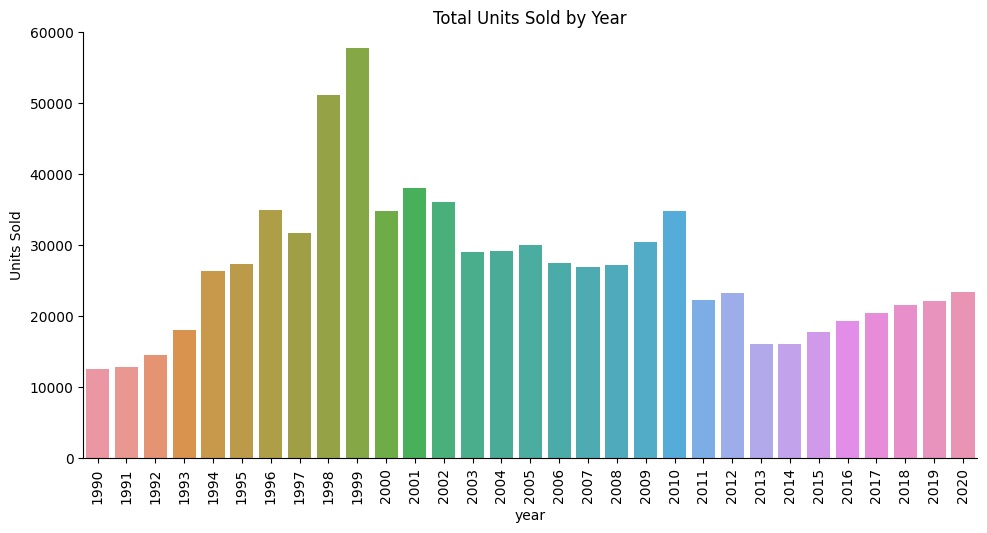

In [ ]:
df_units_sold_year = df_clean_data.filter(items=['year', 'month']).groupby('year').count().reset_index().rename(columns={'month': "Units Sold"})

graph_units_sold_year = sns.catplot(data=df_units_sold_year, y='Units Sold', x='year', kind='bar', dodge=False, aspect=2)
graph_units_sold_year.set_xticklabels(rotation=90)
graph_units_sold_year.set(title="Total Units Sold by Year", ylim=(0, 60000)) 

Let's also take a look at the **percentage of units sold per flat type**. Here, we see that 4-bedroom units account for the highest percentage of sales at 37.5%, 1- and 2-bedroom units combined account less than 2%, whereas the `MULTI GENERATION` and `EXECUTIVE` combined account for almost 8%.

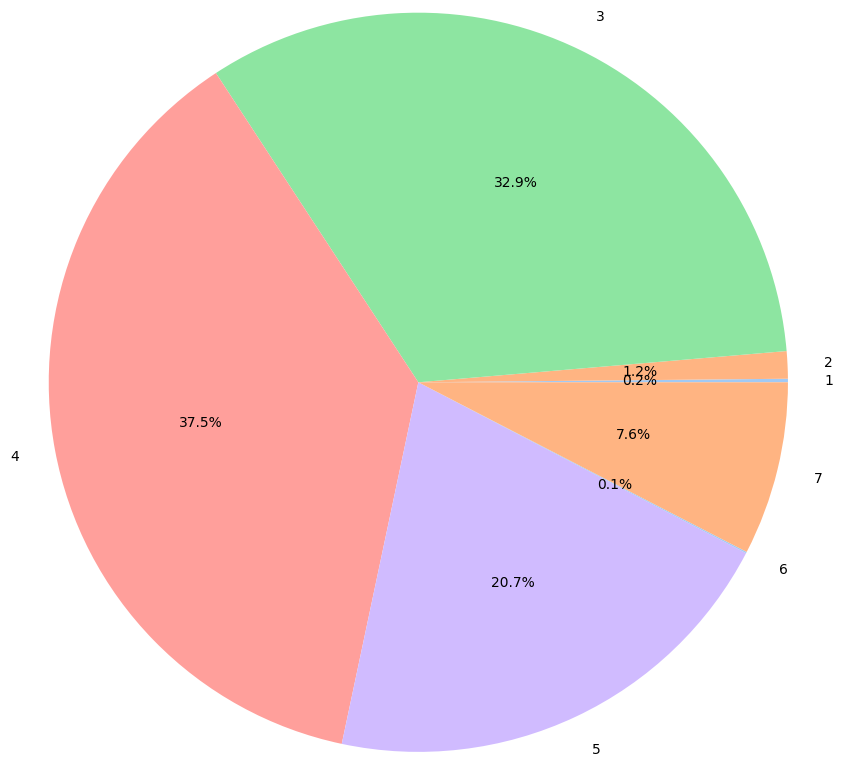

In [ ]:
df_dist_rooms = df_clean_data.filter(items=['year', 'flat_type']).groupby('flat_type').count().reset_index().rename(columns={'year':'Units Sold'})

colors = sns.color_palette('pastel')[0:5]
pie_dist_rooms = plt.pie(df_dist_rooms['Units Sold'], labels = df_dist_rooms['flat_type'], colors=colors, autopct='%.1f%%', radius=2.5)

Next, let's take a look at the **average resale price** for each year.

Here, we observe a cyclical trend of an uptick in price followed by a correction, and then general stability for a limited period. For example, prices rose steadily from 1990 until 1997, before correcting in 1998, and then plateauing until 2006. The cycle repeats with prices rising from 2007 until 2014, followed by a correction in 2015, and then a period of relatively stable prices until 2020. At the end of the series, we observe what appears to be the start of another uptick in prices starting at the end of 2020.

[Text(0.5, 1.0, 'Average Resale Price by Year'),
 (1990.0, 2020.0),
 (0.0, 500000.0)]

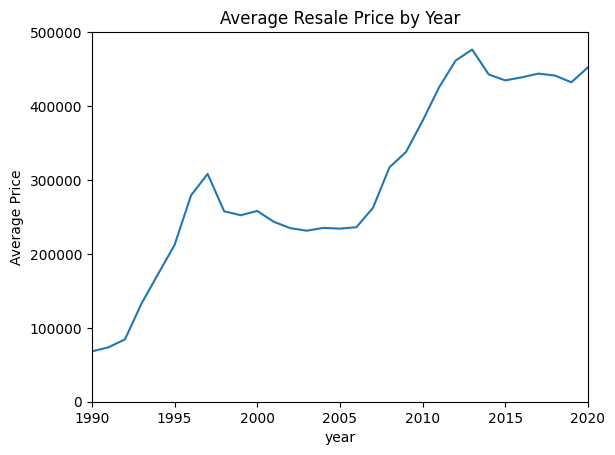

In [ ]:
df_avg_price_year = df_clean_data.filter(items=['year', 'resale_price']).groupby('year').mean().reset_index().rename(columns={'resale_price':'Average Price'})

graph_avg_price_year = sns.lineplot(data=df_avg_price_year, x='year', y='Average Price')
graph_avg_price_year.set(title="Average Resale Price by Year", xlim=(1990, 2020), ylim=(0, 500000))

To get a better understanding of the apartment units in the market, let's take a look at the **average size (in square meters) of apartments sold** by year. 

We observe that while there was an upward trend in average size from 1990 until 2002, it has otherwise remained more or less constant from 2003 onwards (hovering around 93sqm).

[Text(0.5, 1.0, 'Average Size (square meters) by Year'),
 (1990.0, 2020.0),
 (80.0, 100.0)]

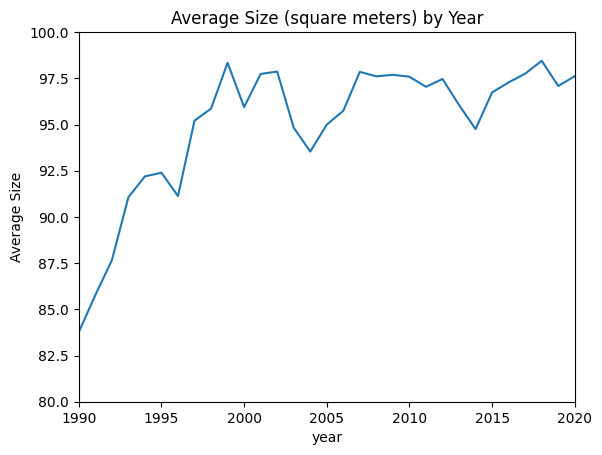

In [ ]:
df_avg_size_year = df_clean_data.filter(items=['year', 'area_sqm']).groupby('year').mean().reset_index().rename(columns={'area_sqm':'Average Size'})

graph_avg_size_year = sns.lineplot(data=df_avg_size_year, x='year', y='Average Size')
graph_avg_size_year.set(title="Average Size (square meters) by Year", xlim=(1990, 2020), ylim=(80, 100))

**Correlation Analysis**

To better understand which attributes are closely related to resale price, we need to construct a **correlation matrix**. 

However, before we can do so, we first need to isolate continuous attributes from the dataset and place them in a new dataframe called `df_cont_attr`. After that, we can generate the correlation matrix and plot a normalized correlation heatmap.

Here, we are primarily interested to see which attribute is the most strongly correlated to `resale_price`. From the heatmap, it appears to be `Core CPI`.

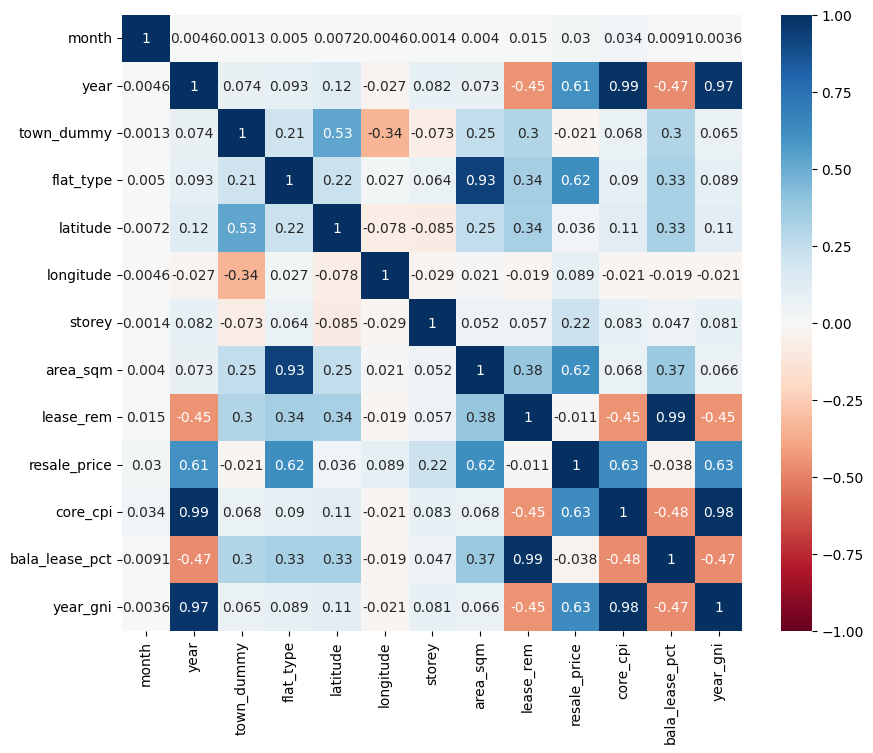

In [ ]:
df_cont_attr = df_clean_data.drop(columns=['town', 'flat_model'])
corr_matrix = df_cont_attr.corr()
fig, ax = plt.subplots(figsize=(10, 8))
corr_heatmap = sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True)

We also understand that some columns are highly-correlated (`year`, `lease_rem`, `year_gni`), which we can drop.

However, before doing so, we first need to get the latest index of each period for partitioning later on. This is because in the next section, we will be partitioning the dataframe to 3 period (`90s`, `00s` and `10s`).

In [ ]:
# Get max index of each period
max_idx_90s = df_clean_data.loc[(df_clean_data['year'] >= 1990) & (df_clean_data['year'] <= 1999)].index.max()
max_idx_00s = df_clean_data.loc[(df_clean_data['year'] >= 2000) & (df_clean_data['year'] <= 2009)].index.max()
max_idx_10s = df_clean_data.loc[df_clean_data['year'] >= 2010].index.max()

print(max_idx_90s, max_idx_00s, max_idx_10s)

287199 596527 833805


In [ ]:
# Remove highly-correlated columns
df_clean_data.drop(['year',
              'lease_rem', 
              'year_gni'], axis=1, inplace=True)

To see how `core_cpi` and `resale price` might be correlated, we plot a scatterplot of these two attributes.

Here, we can see that although there is a generally positive correlation between the two attributes, the spread of resale price values at each `core_cpi` value is rather large. Therefore even though `core_cpi` has the highest correlation to `resale price`, we cannot rely solely on it to be an accurate predictor of `resale price`.

[Text(0.5, 1.0, 'Resale Price vs Core CPI')]

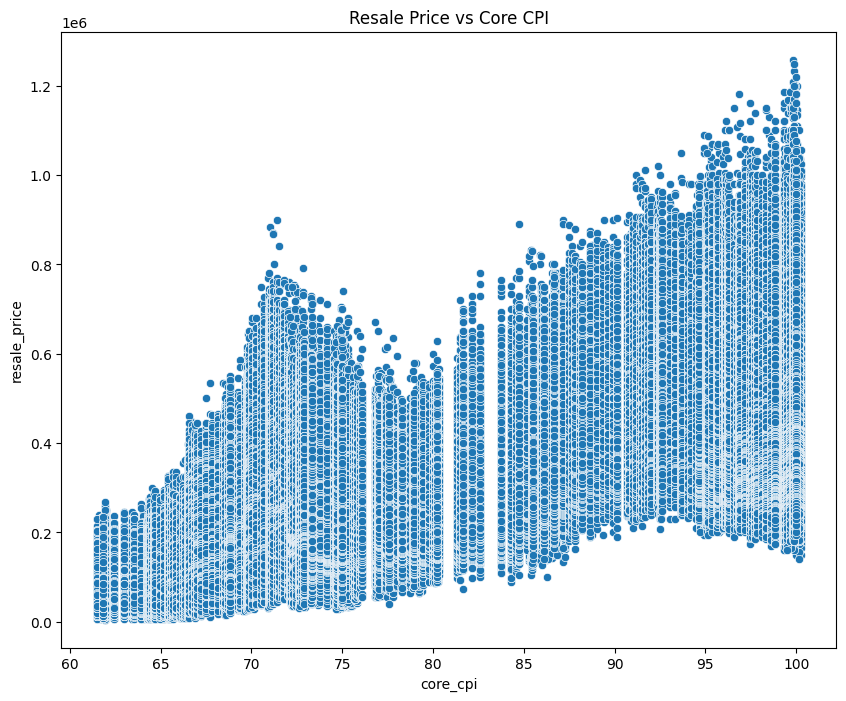

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
splot_price_cpi = sns.scatterplot(data=df_clean_data, x="core_cpi", y="resale_price")
splot_price_cpi.set(title="Resale Price vs Core CPI")

# Feature Engineering


Our final cleaned data from the previous section looks as follows.

In [ ]:
df_clean_data.sample(10)

,month,town,town_dummy,flat_type,latitude,longitude,storey,area_sqm,flat_model,resale_price,core_cpi,bala_lease_pct
673764,11,bedok,4,4,1.336599,103.920398,2,93.0,new_generation,431000.0,91.679,84.5
361206,1,choa_chu_kang,6,7,1.380211,103.737390,5,143.0,maisonette,419000.0,74.552,95.4
527877,8,choa_chu_kang,6,4,1.380078,103.746071,2,105.0,model_a,215000.0,81.500,91.8
169293,9,geylang,3,4,1.328751,103.904234,5,84.0,simplified,260000.0,72.547,93.6
15023,3,hougang,4,4,1.374132,103.895191,14,91.0,new_generation,72000.0,63.912,95.4
812604,2,bukit_batok,6,4,1.364799,103.745027,11,94.0,new_generation,325000.0,100.142,84.2
241147,3,choa_chu_kang,6,5,1.393273,103.742509,8,119.0,improved,347000.0,72.429,95.4
426598,1,jurong_west,5,5,1.339089,103.696557,5,120.0,improved,282000.0,76.805,95.2
435372,4,woodlands,5,4,1.439796,103.803073,5,105.0,premium_apartment,245000.0,77.063,95.6
680517,3,woodlands,5,7,1.441320,103.791966,8,177.0,apartment,715000.0,92.325,91.4


Here is an overview of the steps we will take to prepare the training and test datasets for each of the two rounds of model training.

1. Split the datasets
  - Round 1
      - 1 train set: Period 1 (90s)
      - 2 test sets: Period 2 (00s), Period 3 (10s)
  - Round 2
      - 1 train set: Period 2 (00s)
      - 1 test set: Period 3 (10s)
2. Fit the scaler on the train set
3. Transform the train set using fitted scaler
4. Fit the PCA on the train set and get the optimal # of components
5. Transform the train set using fitted PCA
6. Transform the test set(s) using fitted scaler from train part
7. Transform the test set(s) using fitted PCA from train part

Since we are going to train the model using data from one period (e.g. 1990's) and then test in another (e.g. 2000's), we need to ensure that any categorical variable(s) that exist in one period also exists in all other periods. 

Therefore, we will remove entries in the categorical variables (`town` & `flat_model`) that **do not exist** in all three periods. These entries account for only 3% of total data, so dropping them will have minimal impact on the overall dataset.

In [ ]:
# partition the dataset into 3 periods --> 1990's, 2000's and 2010's
df_clean_90s = df_clean_data.copy().loc[:max_idx_90s]
df_clean_00s = df_clean_data.copy().loc[max_idx_90s+1:max_idx_00s]
df_clean_10s = df_clean_data.copy().loc[max_idx_00s+1:]

In [ ]:
# find unique values for town and flat_model
unique_town_all_period = [t for df in [df_clean_90s, df_clean_00s, df_clean_10s] for t in df['town'].unique()]
unique_flat_model_all_period = [f for df in [df_clean_90s, df_clean_00s, df_clean_10s] for f in df['flat_model'].unique()]

# find values that are not present in all 3 periods
invalid_town = [t for t in set(unique_town_all_period) if unique_town_all_period.count(t) < 3]
invalid_flat_model = [f for f in set(unique_flat_model_all_period) if unique_flat_model_all_period.count(f) < 3]

In [ ]:
# calculate the number of invalid values as a percentage of the total data
num_invalid = ((df_clean_data['flat_model'].isin(invalid_flat_model)) | (df_clean_data['town'].isin(invalid_town))).sum()
print("The number of invalid entries is {} ({}% of total {}).".format(num_invalid, round(num_invalid/len(df_clean_data) * 100, 2), len(df_clean_data)))

# Drop the invalid entries from each period
dfs = [df_clean_90s, df_clean_00s, df_clean_10s]

for i, df in enumerate(dfs):
  mask = df['flat_model'].isin(invalid_flat_model) | df['town'].isin(invalid_town)
  dfs[i] = df[~mask]
  
df_clean_90s, df_clean_00s, df_clean_10s = dfs

The number of invalid entries is 25608 (3.07% of total 833806).


## Round 1

We are now going to apply PCA preprocessing, following the steps below:
- Perform one-hot encoding on the categorical columns
- Scale the data
- Fit the PCA and find the optimal number of PCs (at least 80% of captured variance)
- Transform the entire dataframe into columns of PCs

In the plot below, observe that we identified the optimal # of principal components to be 29.

## Principal Component Analysis (PCA)

In [ ]:
# specify the train and test sets
df_clean_round_1_train = df_clean_90s
df_clean_round_1_test_a = df_clean_00s
df_clean_round_1_test_b = df_clean_10s

In [ ]:
def preprocess_pca_train(df):

  # step 1: perform one-hot encoding on the categorical columns
  df = pd.get_dummies(df)
  features = df.drop(columns=['resale_price'])
  target = df[['resale_price']].reset_index(drop=True)

  # step 2: scale the data
  scaler = StandardScaler().fit(features)
  df_scaled = scaler.transform(features)

  # step 3: fit the PCA, find the optimal number of PCs
  pca = PCA().fit(df_scaled)
  explained_variance_ratios = pca.explained_variance_ratio_
  cum_evr = np.cumsum(explained_variance_ratios)
  opt_pc = 0
  for pc in range(len(cum_evr)):
    opt_pc += 1
    if cum_evr[pc] >= 0.8:
      break
  print("# of Principal Components retained: {}".format(opt_pc))
  num_components = range(1, len(explained_variance_ratios)+1)
  plt.figure(figsize=(10, 8))
  plt.plot(num_components, cum_evr, 'bo-', linewidth=2)
  plt.axhline(y=0.8, color='g', linestyle='--')
  plt.xlabel('Number of Components')
  plt.ylabel('Cumulative Explained Variance Ratio')
  plt.title('Cumulative Explained Variance Ratio vs Number of Components')

  # step 4: transform the dataset on PCA on optimal # of PCs, plot the explained variance ratio
  pca_fixed = PCA(n_components=opt_pc)
  df_clean_pca = pca_fixed.fit_transform(df_scaled)
  df_clean_pca = pd.DataFrame(df_clean_pca, columns=["pca_{}".format(i+1) for i in range(opt_pc)])
  df_clean_pca['resale_price'] = target
  plt.show()

  return df_clean_pca, scaler, pca_fixed

In [ ]:
def preprocess_pca_test(df, scaler, pca):

  # step 1: perform one-hot encoding on the categorical columns
  df = pd.get_dummies(df)
  features = df.drop(columns=['resale_price'])
  target = df[['resale_price']].reset_index(drop=True)

  # step 2: transform the data using fitted scaler
  df_scaled = scaler.transform(features)

  # step 3: transform the data using fitted PCA
  df_clean_pca = pca.transform(df_scaled)
  df_clean_pca = pd.DataFrame(df_clean_pca, columns=["pca_{}".format(i+1) for i in range(pca.n_components_)])
  df_clean_pca['resale_price'] = target
  plt.show()

  return df_clean_pca

# of Principal Components retained: 29


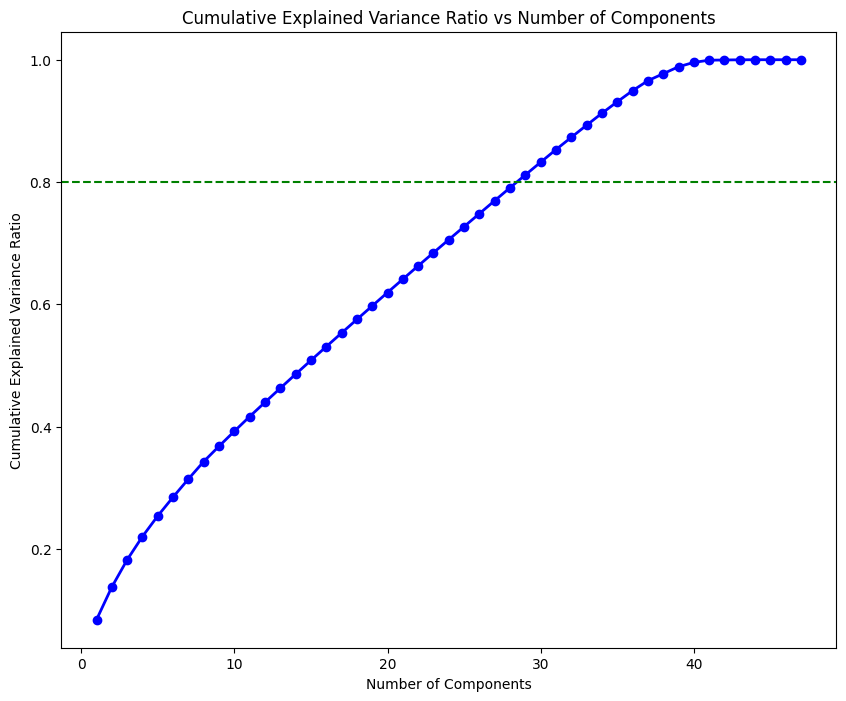

In [ ]:
df_clean_round_1_train, round_1_scaler, round_1_pca = preprocess_pca_train(df_clean_round_1_train)

Next, we plot the first 5 rows of each train and test dataset to preview the results. For each of the test sets, we transform them using the scaler and pca that was previously fitted on the train set.

In [ ]:
df_clean_round_1_train.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,resale_price
0,-1.392042,-0.618478,-1.781022,2.645547,0.014456,0.638307,0.629140,0.393982,1.471664,-0.886769,...,-0.166448,0.012472,1.323004,-0.242450,0.195430,-0.003278,0.090866,-0.933656,0.238707,86000.0
1,-1.783662,-1.094724,-2.015880,2.343585,-0.085749,0.726758,0.558810,0.438016,1.477157,-0.713894,...,-0.113010,0.014219,1.329107,-0.162481,0.205386,0.009993,0.077531,-0.957283,0.321987,59000.0
2,-1.852834,-1.277445,-2.127362,2.267333,-0.119948,0.780325,0.422318,0.447315,1.517534,-0.566752,...,-0.074706,0.016648,1.347316,-0.096850,0.209644,0.019571,0.064114,-0.959081,0.389607,47200.0
3,-2.032780,-1.201840,-1.992918,2.269977,-0.024277,0.678002,0.696488,0.412883,1.371648,-0.854683,...,-0.145708,0.004855,1.296230,-0.217748,0.210937,0.009713,0.081343,-0.960091,0.251537,47200.0
4,-1.347033,-0.911823,-2.029807,2.534315,-0.064426,0.776620,0.368310,0.401918,1.563629,-0.607423,...,-0.085592,0.011650,1.371490,-0.107450,0.201480,0.011708,0.075866,-0.940583,0.379270,80000.0


In [ ]:
df_clean_round_1_test_a = preprocess_pca_test(df_clean_round_1_test_a, round_1_scaler, round_1_pca)

In [ ]:
df_clean_round_1_test_a.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,resale_price
0,-2.054433,-1.273812,-1.791645,1.929987,0.297222,0.009083,0.229633,1.885847,0.959474,0.239961,...,-0.315331,0.643383,0.673870,-0.316223,0.239059,0.222602,-0.449891,-0.928312,0.131400,138500.0
1,-2.124341,-1.174124,-1.618541,1.984078,0.421288,-0.086850,0.507252,1.870115,0.840472,-0.051900,...,-0.387018,0.630805,0.627393,-0.439601,0.238478,0.210544,-0.430009,-0.928521,-0.006705,148000.0
2,-1.891659,-1.151908,-1.747102,1.982918,0.390108,-0.010030,0.534408,1.825185,0.819291,-0.080460,...,-0.372057,0.612872,0.644648,-0.423801,0.239292,0.206689,-0.407824,-0.935261,0.004430,153000.0
3,-1.847478,-1.226877,-1.813426,1.966791,0.339704,0.045422,0.396003,1.838138,0.880877,0.064977,...,-0.335758,0.618202,0.668381,-0.362099,0.239816,0.212869,-0.417606,-0.935102,0.073771,157000.0
4,-2.054274,-1.087020,-1.808874,1.921151,0.250204,-0.019347,0.371403,1.816879,0.860828,0.087013,...,-0.345187,0.634537,0.655900,-0.370338,0.237947,0.214554,-0.429808,-0.929462,0.069772,155000.0


In [ ]:
df_clean_round_1_test_b = preprocess_pca_test(df_clean_round_1_test_b, round_1_scaler, round_1_pca)

In [ ]:
df_clean_round_1_test_b.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,resale_price
0,-2.766439,-0.956553,-0.969246,1.637261,1.022404,-1.196550,0.540090,3.492677,0.147378,0.583971,...,-0.746713,1.331125,-0.198159,-0.837119,0.272030,0.426363,-1.012000,-0.865710,-0.459506,231000.0
1,-1.964266,-0.217513,-0.953793,1.964143,0.912565,-1.164350,0.489046,3.375128,0.182887,0.533531,...,-0.748300,1.321660,-0.160855,-0.844198,0.259530,0.409980,-0.980645,-0.836102,-0.459576,315000.0
2,-2.435822,-1.240613,-1.384935,1.529692,0.858795,-0.947026,0.162860,3.478275,0.295718,0.984158,...,-0.619142,1.323344,-0.109245,-0.629410,0.276992,0.442620,-1.016973,-0.877922,-0.240116,225000.0
3,-2.046378,-0.167116,-0.193808,0.337924,1.755089,-0.576142,1.753721,2.681603,-0.095659,0.477898,...,-0.635542,1.329215,-0.103869,-0.669581,0.359237,0.447710,-0.849443,-0.882855,-0.280444,202000.0
4,-2.357664,-1.230306,-1.402783,1.539406,0.794561,-0.882092,0.168993,3.432573,0.257407,0.972996,...,-0.609248,1.314670,-0.100707,-0.619670,0.277695,0.441460,-1.004289,-0.879448,-0.229705,226000.0


### Round 2

For `ROUND 2`, we repeat the same process as above. Note that this time, we will use the 2000's data as the train set and 2010's data as the test set.

For this round, the optimal number of principal components is also 29, as shown in the plot below.

In [ ]:
# specify train and test sets
df_clean_round_2_train = df_clean_00s
df_clean_round_2_test = df_clean_10s

# of Principal Components retained: 29


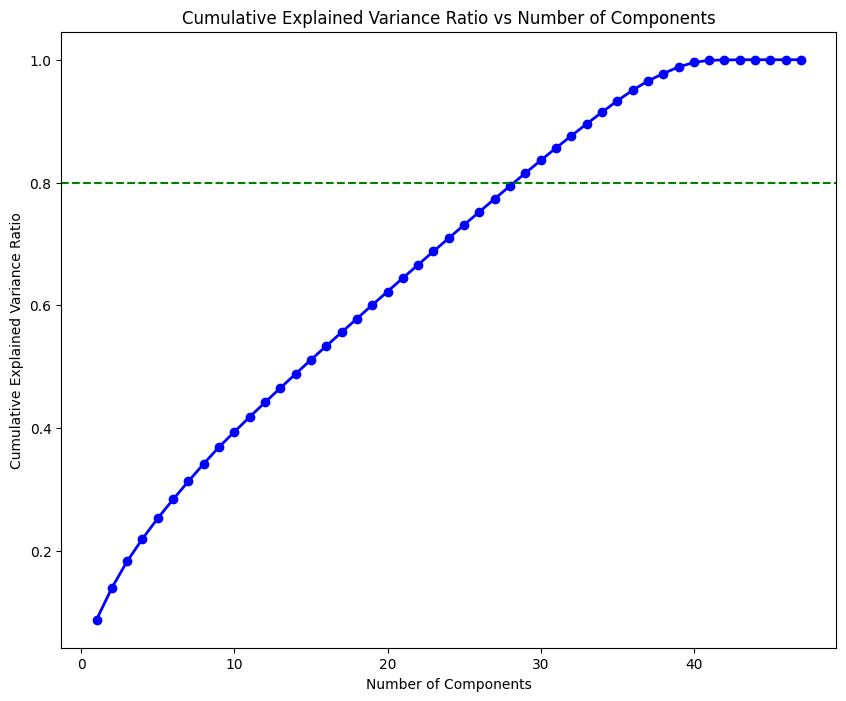

In [ ]:
df_clean_round_2_train, round_2_scaler, round_2_pca = preprocess_pca_train(df_clean_round_2_train)

Next, we plot the first 5 rows of each train and test dataset to preview the results. For the test set, we transform it using the scaler and pca that was previously fitted on the train set.

In [ ]:
df_clean_round_2_train.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,resale_price
0,-2.330524,-1.109516,-1.960839,2.552107,-0.402146,-0.762087,0.985835,0.667983,1.434039,0.072995,...,0.588412,-0.578985,-0.202440,0.231403,-0.615773,1.033183,0.497096,0.075789,-0.421846,138500.0
1,-2.296141,-1.000824,-1.705401,2.550455,-0.256761,-1.073755,0.983659,0.598443,1.355948,-0.345266,...,0.701517,-0.606770,-0.166443,0.091747,-0.718707,1.049236,0.469231,-0.033516,-0.404173,148000.0
2,-2.142199,-0.950132,-1.796150,2.531296,-0.256014,-1.119154,1.008902,0.599674,1.357595,-0.369169,...,0.706987,-0.599052,-0.163286,0.092425,-0.718100,1.063599,0.469000,-0.045216,-0.393085,153000.0
3,-2.146715,-1.029804,-1.906101,2.541522,-0.322293,-0.959267,1.020759,0.635605,1.401010,-0.159244,...,0.650209,-0.584797,-0.180760,0.162050,-0.666835,1.055418,0.483152,0.009468,-0.401843,157000.0
4,-2.324252,-0.915934,-1.903273,2.501423,-0.399031,-0.958404,0.952729,0.618345,1.361269,-0.156104,...,0.649652,-0.590231,-0.186697,0.165217,-0.666340,1.048110,0.483605,0.017440,-0.407193,155000.0


In [ ]:
df_clean_round_2_test = preprocess_pca_test(df_clean_round_2_test, round_2_scaler, round_2_pca)

In [ ]:
df_clean_round_2_test.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,resale_price
0,-2.883321,-0.889404,-1.124580,2.777909,0.584040,-1.274328,0.330093,1.150379,0.373943,0.001333,...,0.406909,-0.616915,-0.208111,-0.004042,-0.614706,0.599766,0.356475,-0.042359,-0.468917,231000.0
1,-2.146821,-0.106565,-1.056857,3.031691,0.387475,-1.187521,0.323781,1.171467,0.316571,0.026080,...,0.410021,-0.648271,-0.215265,-0.000849,-0.662310,0.588979,0.373851,-0.071235,-0.492734,315000.0
2,-2.805418,-1.150109,-1.622959,2.744542,0.433422,-0.859780,0.385834,1.259184,0.506336,0.591830,...,0.243955,-0.565507,-0.253225,0.197999,-0.458557,0.599383,0.396984,0.116847,-0.488179,225000.0
3,-2.151877,-0.082401,-0.203108,1.342926,1.688459,-1.610886,0.594603,-0.045521,0.627172,0.007718,...,0.481844,-0.625645,-0.168188,0.061626,-0.534948,0.743456,0.438842,-0.008419,-0.468499,202000.0
4,-2.764544,-1.138484,-1.613553,2.730978,0.391034,-0.887201,0.406561,1.247327,0.489326,0.570766,...,0.248510,-0.560919,-0.252420,0.199553,-0.458734,0.608029,0.398697,0.114688,-0.482097,226000.0


# Model Training & Predictions

Now that we have cleaned and pre-processed the train and test datasets, we are finally ready to begin training our models!

# scikit-learn
Here we fit the data to various models using scikit learn. After training the models on the training data, we will check how well the models run using the training data and calculate the metric MSE (mean squared error).

The DataFrame `results` will store the results of each model

In [ ]:
from sklearn.metrics import mean_squared_error
results = pd.DataFrame(columns = ["model", "round 1 train MSE", "round 1 a test MSE", "round 1 b test MSE", "round 2 train MSE", "round 2 test MSE"])

We define a function `run_regression` to run each specified scikit-learn regression on the `ROUND 1` and `ROUND 2` datasets.

The variable `target` stores the name of the column with the variable that is being predicted by the regression.

In [ ]:
target = "resale_price"

def run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {}):
  #round 1
  X = df_clean_round_1_train.drop(target, axis = 1)
  y = df_clean_round_1_train[target]
  reg = current_regressor(**hyperparameters).fit(X, y)
  round_1_train_predictions = reg.predict(X)
  round_1_train_mse = mean_squared_error(y ,round_1_train_predictions)

  round_1_test_a_predictions = reg.predict(df_clean_round_1_test_a.drop(target, axis = 1))
  round_1_test_a_mse = mean_squared_error(df_clean_round_1_test_a[target], round_1_test_a_predictions)

  round_1_test_b_predictions = reg.predict(df_clean_round_1_test_b.drop(target, axis = 1))
  round_1_test_b_mse = mean_squared_error(df_clean_round_1_test_b[target], round_1_test_b_predictions)

  #round 2
  X = df_clean_round_2_train.drop(target, axis = 1)
  y = df_clean_round_2_train[target]
  reg_2 = current_regressor(**hyperparameters).fit(X, y)
  round_2_train_predictions = reg_2.predict(X)
  round_2_train_mse = mean_squared_error(y, round_2_train_predictions)

  round_2_test_predictions = reg_2.predict(df_clean_round_2_test.drop(target, axis = 1))
  round_2_test_mse = mean_squared_error(df_clean_round_2_test[target], round_2_test_predictions)

  return [str(reg), round_1_train_mse,  round_1_test_a_mse, round_1_test_b_mse, round_2_train_mse, round_2_test_mse]


## Linear Models

### Ordinary Least Squares

This is a simple linear regression model. There are no hyperparameters.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
from sklearn.linear_model import LinearRegression
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, LinearRegression, target)
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10


### Lasso Regression

This is a linear model that is lasso regularized. We try models with three different sets of hyperparameters with alpha set to 1, 10, and 100.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
from sklearn.linear_model import Lasso
current_regressor = Lasso
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":1.0})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":10})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":100})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
2,Lasso(alpha=10),2.812521e+10,4.943194e+10,2.296289e+10
3,Lasso(alpha=100),2.627587e+10,4.602766e+10,2.306260e+10


### Ridge

This is a linear model that is ridge regularized. We try models with three different sets of hyperparameters with alpha set to 1, 10, and 100.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
from sklearn.linear_model import Ridge
current_regressor = Ridge
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":1.0})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":10})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":100})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
6,Ridge(alpha=100),2.831693e+10,4.978123e+10,2.295565e+10
2,Lasso(alpha=10),2.812521e+10,4.943194e+10,2.296289e+10
3,Lasso(alpha=100),2.627587e+10,4.602766e+10,2.306260e+10


### Elastic Net

This is a linear model that is  elasticnet regularized. We try models with three different sets of hyperparameters with alpha set to 1, 10, and 100. We could have chosen to alter the `l1_ratio`, but did not for brevity. In a deeper analysis we could try altering the `l1_ratio`.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
from sklearn.linear_model import ElasticNet
current_regressor = ElasticNet
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":1.0})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":10})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"alpha":100})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
6,Ridge(alpha=100),2.831693e+10,4.978123e+10,2.295565e+10
2,Lasso(alpha=10),2.812521e+10,4.943194e+10,2.296289e+10
3,Lasso(alpha=100),2.627587e+10,4.602766e+10,2.306260e+10
7,ElasticNet(),1.334475e+10,2.346983e+10,2.751313e+10
8,ElasticNet(alpha=10),5.600250e+09,3.634051e+10,3.967063e+10
9,ElasticNet(alpha=100),9.826375e+09,5.824598e+10,4.650568e+10


## Ensemble Methods

### ADA Boost

This is our first non-linear model. All of the following models are non-linear. This is a simple ADA boost model with varying number of estimators from 50 to 500. We kept the default estimator and learning rate, but these could be varied in a deep analysis. 

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
current_regressor = AdaBoostRegressor
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":10})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":50})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":100})
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":500})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
13,AdaBoostRegressor(n_estimators=500),1.115377e+10,1.286550e+10,1.347960e+10
12,AdaBoostRegressor(n_estimators=100),6.368150e+09,1.473444e+10,1.565962e+10
11,AdaBoostRegressor(),4.570916e+09,1.912888e+10,1.757644e+10
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
6,Ridge(alpha=100),2.831693e+10,4.978123e+10,2.295565e+10
2,Lasso(alpha=10),2.812521e+10,4.943194e+10,2.296289e+10
3,Lasso(alpha=100),2.627587e+10,4.602766e+10,2.306260e+10


### Random Forest

This is a random forest model with different number of estimators from 10 to 50. Originally we tried more estimators, but due to compute restraints we limited ourselves to 50 estimators.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
current_regressor = RandomForestRegressor
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":10})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)


,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
13,AdaBoostRegressor(n_estimators=500),1.115377e+10,1.286550e+10,1.347960e+10
14,RandomForestRegressor(n_estimators=10),3.528126e+09,3.076458e+10,1.413388e+10
12,AdaBoostRegressor(n_estimators=100),6.368150e+09,1.473444e+10,1.565962e+10
11,AdaBoostRegressor(),4.570916e+09,1.912888e+10,1.757644e+10
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
6,Ridge(alpha=100),2.831693e+10,4.978123e+10,2.295565e+10
2,Lasso(alpha=10),2.812521e+10,4.943194e+10,2.296289e+10


In [ ]:
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"n_estimators":50})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
13,AdaBoostRegressor(n_estimators=500),1.115377e+10,1.286550e+10,1.347960e+10
15,RandomForestRegressor(n_estimators=50),3.342953e+09,2.933198e+10,1.405211e+10
14,RandomForestRegressor(n_estimators=10),3.528126e+09,3.076458e+10,1.413388e+10
12,AdaBoostRegressor(n_estimators=100),6.368150e+09,1.473444e+10,1.565962e+10
11,AdaBoostRegressor(),4.570916e+09,1.912888e+10,1.757644e+10
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10
6,Ridge(alpha=100),2.831693e+10,4.978123e+10,2.295565e+10


## Multilayer Perceptron

This is a basic multilayer perceptron. Due to compute restraints we limited ourselves to a single model with default hyperparameters. This model very likely could be improved in a deeper analysis (and with more compute power) by changing the hyperparameters and/or using a more powerful library such as pytorch.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
from sklearn.neural_network import MLPRegressor
current_regressor = MLPRegressor
results.loc[len(results)] = run_regression(df_clean_round_1_train, df_clean_round_1_test_a, df_clean_round_1_test_b, df_clean_round_2_train, df_clean_round_2_test, current_regressor, target, hyperparameters = {"activation":"relu"})
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
16,MLPRegressor(),2.799145e+10,1.185270e+11,9.608658e+09
13,AdaBoostRegressor(n_estimators=500),1.115377e+10,1.286550e+10,1.347960e+10
15,RandomForestRegressor(n_estimators=50),3.342953e+09,2.933198e+10,1.405211e+10
14,RandomForestRegressor(n_estimators=10),3.528126e+09,3.076458e+10,1.413388e+10
12,AdaBoostRegressor(n_estimators=100),6.368150e+09,1.473444e+10,1.565962e+10
11,AdaBoostRegressor(),4.570916e+09,1.912888e+10,1.757644e+10
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10
1,Lasso(),2.831481e+10,4.978176e+10,2.295296e+10


# Redshift ML

In this section, we will be training Auto ML models using Redshift ML. The same train and test sets that were used for the scikit-learn model will be used here.

**Note**: For this section, some parts of the process that are repetitive are omitted for the sake of brevity. Furthermore, all code in this section is commented out so as to avoid any unexpected behavior from running Redshift commands in this notebook.

In order to ingest data into Redshift for model training, first we export the training and test `dataframes` as `csv` files and upload them to an S3 bucket.

Next, we spin up a **Redshift Serverless** cluster to import the data. We use the `Redshift Query Editor` to create new tables for each training and test dataset in Redshift and import the corresponding data from S3 using the `SQL` query shown below. 

(This command is used to import the `ROUND 1` training data. Similar commands are used to import all other required datasets as well, but are omitted for brevity)

In [ ]:
# CREATE TABLE rs_train_round_1 (
#     pca_1 float, pca_2 float, pca_3 float, pca_4 float, pca_5 float, pca_6 float, pca_7 float, pca_8 float, pca_9 float, pca_10 float,
#     pca_11 float, pca_12 float, pca_13 float, pca_14 float, pca_15 float, pca_16 float, pca_17 float, pca_18 float, pca_19 float, pca_20 float,
#     pca_21 float, pca_22 float, pca_23 float, pca_24 float, pca_25 float, pca_26 float, pca_27 float, pca_28 float, pca_29 float,
#     resale_price float
# );

# COPY rs_train_round_1
# FROM 's3://545-redshift-serverless/df_clean_round_1_train.csv'
# REGION 'ap-northeast-1' IAM_ROLE default
# FORMAT AS CSV IGNOREHEADER 1;

With the data loaded into Redshift, we can begin training an Auto ML model using **Redshift ML**. For `ROUND 1`, we start by training the model using data from the 1990's, which we will later use to make predictions on test data from the 2000's and 2010's. 

The `SQL` command shown below is used to train the model.

* `CREATE MODEL` specifies the name of the model to be created.

* `SELECT *` selects all attributes in the `rs_train_round_1` dataset to be used for training.

* Then, `TARGET` identifies the attribute that we would like the model to make predictions on.

* We also define a `FUNCTION` name, which we will call in future queries to invoke this ML model.

* Finally, we specify an `IAM` role with appropriate permissions to execute the model training.

In [ ]:
# CREATE MODEL round_1
# FROM (
#     SELECT *
#     FROM rs_train_round_1
# )
# TARGET resale_price 
# FUNCTION round_1_model
# IAM_ROLE default SETTINGS (
#   S3_BUCKET 'redshift-ml-ab3'
# );

We can view the parameters of the model by calling the `SHOW MODEL` command below. The output is shown in the cell that follows.

In [ ]:
# SHOW MODEL round_1;

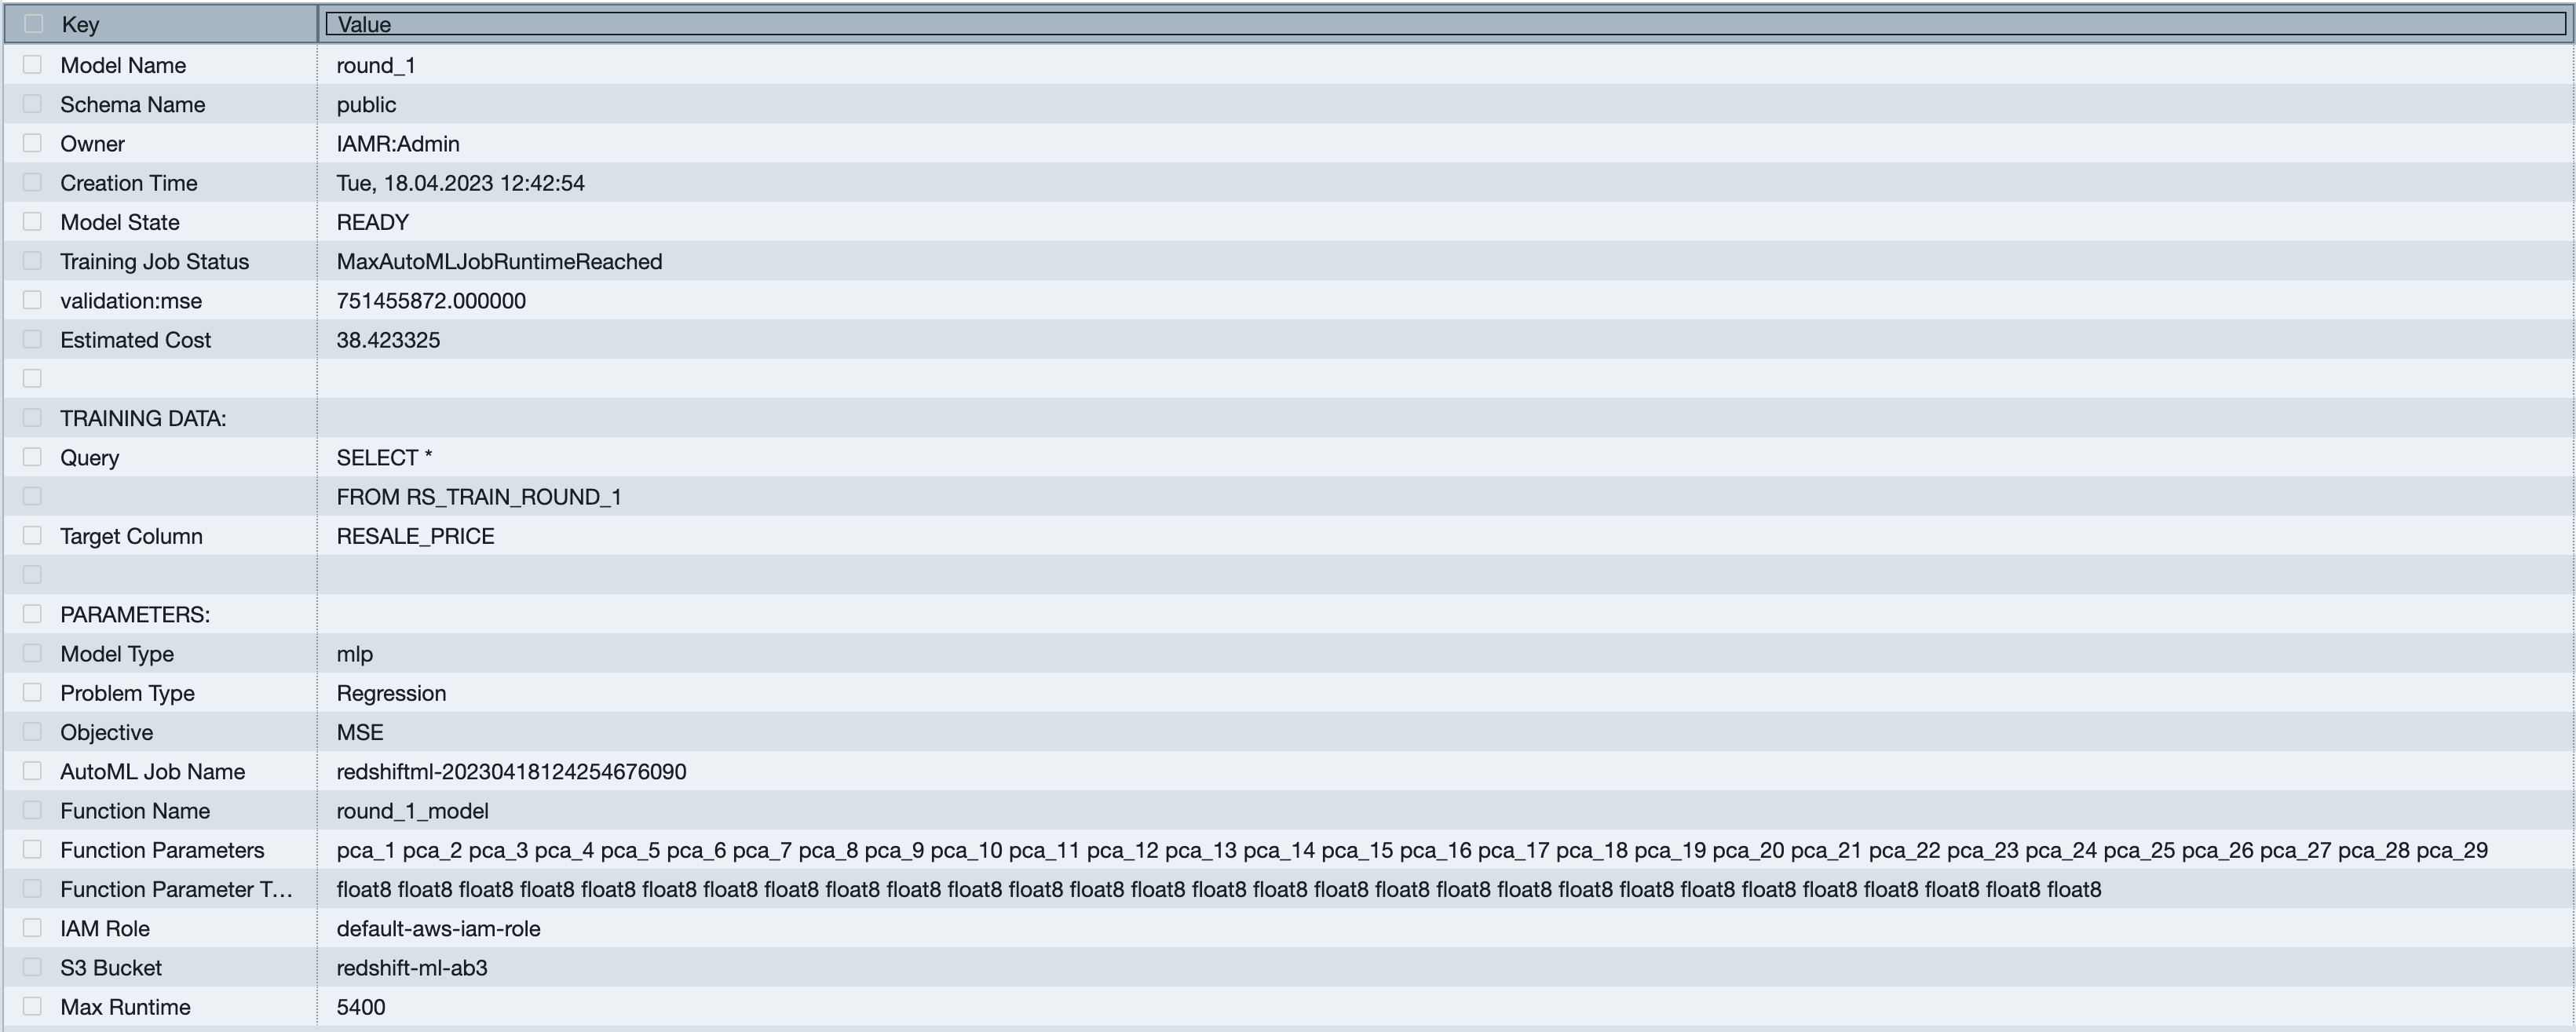

Now that we have trained the ML model on data from the 1990's, it's time to **make predictions** on the resale price of the 2000's and 2010's! 

(For brevity, only the 2000's resale price predictions are shown below)

This is done using a familiar `SQL` format, where we `SELECT` the original `resale_price` and also `pred_price` from the model (which we call using the previously-defined `FUNCTION` name, `round_1_model`. The function is passed attributes from the test dataset to be used by the model to make predictions on the previously-defined `TARGET` attribute, `resale_price`). Note that we include the original `resale_price` values in the output, as we will need it to compute the prediction accuracy later on.

The `UNLOAD` command simply tells Redshift to write the query output to a `csv` file in `S3`, which we will import into this notebook later on to evaluate prediction accuracy.

The first 10 rows of the actual vs predicted resale prices are shown in the cell that follows.

In [ ]:
# UNLOAD(
#     'SELECT resale_price, round_1_model(
#         pca_1, pca_2, pca_3, pca_4, pca_5, pca_6, pca_7, pca_8, pca_9, pca_10,
#         pca_11, pca_12, pca_13, pca_14, pca_15, pca_16, pca_17, pca_18, pca_19, pca_20,
#         pca_21, pca_22, pca_23, pca_24, pca_25, pca_26, pca_27, pca_28, pca_29
#     ) AS pred_price
#     FROM rs_test_a_round_1'
# )
# TO 's3://hdb-datasets-jcmlim/predictions/round1-testa/'
# IAM_ROLE default
# CSV
# PARALLEL OFF;

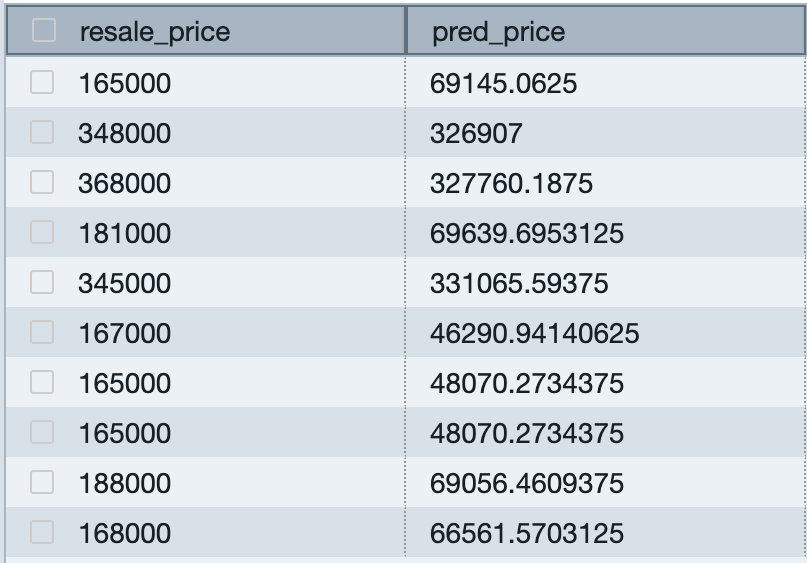

We repeat the step above to make predictions on the 2010's dataset using the same `ROUND 1` model. The output is written to a `csv` file, which we will import into this notebook later on to evaluate and compare prediction accuracy.

Next, for `ROUND 2` we **re-train the model** using training data from the 2000's and use it to make predictions on the 2010's test data. The process is identical to what we've done above, except that we pass the 2000's dataset as the training dataset. 

Then, as before, we use this `ROUND 2` model to make predictions on the 2010's resale price.

The first 10 rows of the prediction results on 2010's test data (this time using the `ROUND 2` model) is copied below.

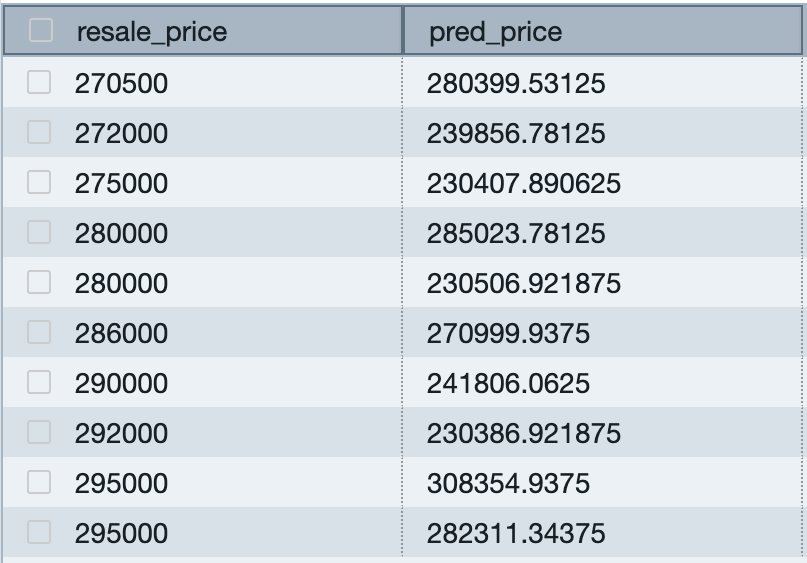

Finally, we import the prediction results from `ROUND 1` and `ROUND 2` (which were previously exported as  `csv` files from Redshift) and load it back into Jupyter Notebook as `dataframes` for further analysis.

Note that for ease of sharing, the `csv` files have been copied from `S3` into `Google Drive`.

In [ ]:
rs_round_1_test_a_url = "https://drive.google.com/file/d/1Xqbbf2qkGPRnjNupZZJRnfNe05TgD07n/view?usp=share_link"
rs_round_1_test_a_dataset = "round_1_test_a.csv"
output = gdown.download(url=rs_round_1_test_a_url, output=rs_round_1_test_a_dataset, quiet=False, fuzzy=True)
df_rs_round_1_test_a = pd.read_csv(rs_round_1_test_a_dataset, header=None)
df_rs_round_1_test_a.columns = ["resale_price", "predicted_price"]

rs_round_1_test_b_url = "https://drive.google.com/file/d/1KQexhz-iGnQzBYvV2ZK0l2dn3Lx_2BCq/view?usp=share_link"
rs_round_1_test_b_dataset = "round_1_test_b.csv"
output = gdown.download(url=rs_round_1_test_b_url, output=rs_round_1_test_b_dataset, quiet=False, fuzzy=True)
df_rs_round_1_test_b = pd.read_csv(rs_round_1_test_b_dataset, header=None)
df_rs_round_1_test_b.columns = ["resale_price", "predicted_price"]

rs_round_2_test_b_url = "https://drive.google.com/file/d/1Uzg9rcw7voIyQ_AqkF6-WAy2lPju9lBZ/view?usp=share_link"
rs_round_2_test_b_dataset = "round_2_test_b.csv"
output = gdown.download(url=rs_round_2_test_b_url, output=rs_round_2_test_b_dataset, quiet=False, fuzzy=True)
df_rs_round_2_test_b = pd.read_csv(rs_round_2_test_b_dataset, header=None)
df_rs_round_2_test_b.columns = ["resale_price", "predicted_price"]

Downloading...
From: https://drive.google.com/uc?id=1Xqbbf2qkGPRnjNupZZJRnfNe05TgD07n
To: /content/round_1_test_a.csv
100%|██████████| 6.05M/6.05M [00:00<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KQexhz-iGnQzBYvV2ZK0l2dn3Lx_2BCq
To: /content/round_1_test_b.csv
100%|██████████| 4.71M/4.71M [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uzg9rcw7voIyQ_AqkF6-WAy2lPju9lBZ
To: /content/round_2_test_b.csv
100%|██████████| 4.21M/4.21M [00:00<00:00, 191MB/s]


In [ ]:
df_rs_round_1_test_a_mse = mean_squared_error(df_rs_round_1_test_a[target], df_rs_round_1_test_a["predicted_price"])
df_rs_round_1_test_b_mse = mean_squared_error(df_rs_round_1_test_b[target], df_rs_round_1_test_b["predicted_price"])
df_rs_round_2_test_mse = mean_squared_error(df_rs_round_2_test_b[target], df_rs_round_2_test_b["predicted_price"])
results.loc[len(results)] = ["Redshift ML", np.nan, df_rs_round_1_test_a_mse, df_rs_round_1_test_b_mse, np.nan, df_rs_round_2_test_mse]
results.sort_values("round 2 test MSE").drop(["round 1 train MSE", "round 2 train MSE"], axis = 1)

,model,round 1 a test MSE,round 1 b test MSE,round 2 test MSE
16,MLPRegressor(),2.799145e+10,1.185270e+11,9.608658e+09
17,Redshift ML,1.917595e+10,1.371907e+11,1.179963e+10
13,AdaBoostRegressor(n_estimators=500),1.115377e+10,1.286550e+10,1.347960e+10
15,RandomForestRegressor(n_estimators=50),3.342953e+09,2.933198e+10,1.405211e+10
14,RandomForestRegressor(n_estimators=10),3.528126e+09,3.076458e+10,1.413388e+10
12,AdaBoostRegressor(n_estimators=100),6.368150e+09,1.473444e+10,1.565962e+10
11,AdaBoostRegressor(),4.570916e+09,1.912888e+10,1.757644e+10
0,LinearRegression(),2.833593e+10,4.982073e+10,2.295185e+10
4,Ridge(),2.833574e+10,4.982033e+10,2.295189e+10
5,Ridge(alpha=10),2.833403e+10,4.981678e+10,2.295223e+10


#Model Analysis and Comparison

In this section, we will evaluate the performance of the various models that we have trained by computing their MSE values for each round of testing. To visualize the performance of the models side-by-side, we plot the MSE scores for each model in a bar plot.

Recall that in `ROUND 1`, we trained the models on data from the 1990's and used made predictions on data from the 2000's (`round 1 a test`) and 2010's (`round 1 b test`). Then in `ROUND 2`, we retrained the models on data from the 2000's and made predictions on data from the 2010's (`round 2 test`)

Furthermore, we will iteratively eliminate models that have poor accuracy until we derive the best model(s).

[Text(0, 0, 'LinearRegression()'),
 Text(1, 0, 'Lasso()'),
 Text(2, 0, 'Lasso(alpha=10)'),
 Text(3, 0, 'Lasso(alpha=100)'),
 Text(4, 0, 'Ridge()'),
 Text(5, 0, 'Ridge(alpha=10)'),
 Text(6, 0, 'Ridge(alpha=100)'),
 Text(7, 0, 'ElasticNet()'),
 Text(8, 0, 'ElasticNet(alpha=10)'),
 Text(9, 0, 'ElasticNet(alpha=100)'),
 Text(10, 0, 'AdaBoostRegressor(n_estimators=10)'),
 Text(11, 0, 'AdaBoostRegressor()'),
 Text(12, 0, 'AdaBoostRegressor(n_estimators=100)'),
 Text(13, 0, 'AdaBoostRegressor(n_estimators=500)'),
 Text(14, 0, 'RandomForestRegressor(n_estimators=10)'),
 Text(15, 0, 'RandomForestRegressor(n_estimators=50)'),
 Text(16, 0, 'MLPRegressor()'),
 Text(17, 0, 'Redshift ML')]

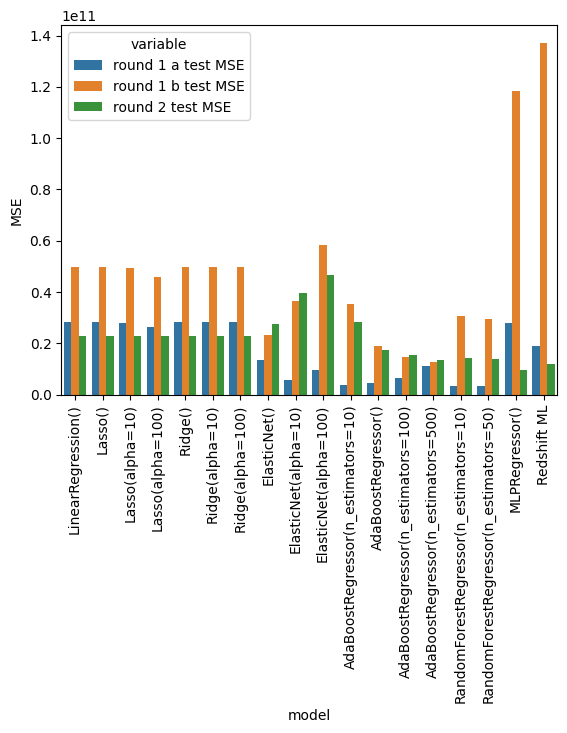

In [ ]:
ax = sns.barplot(pd.melt(results.drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

The first thing to notice is that the `MLPRegressor` and `Redshift ML` models have by far the highest `round 1 b test` MSE, while having the lowest `round 2 test` MSE. This indicates that although they do well on short term data, they do not generalize well to longer term data. 

Furthermore, the `MLPRegressor` and `Redshift ML` models' `round 1 a test` MSE are much higher than some of the Random Forest regressors, while their `round 2 test` MSE is only marginally lower than the Random Forest `round 2 test` MSEs. This indicates that these models' ability to accurately make short term predictions is limited.

Due to their poor performance in both short term and long term prediction accuracy, we will eliminate `Redshift ML` and `MLPRegressor` from the remainder of the analysis.

After taking out `Redshift ML` and `MLPRegressor`, we get the following remaining models.

[Text(0, 0, 'LinearRegression()'),
 Text(1, 0, 'Lasso()'),
 Text(2, 0, 'Lasso(alpha=10)'),
 Text(3, 0, 'Lasso(alpha=100)'),
 Text(4, 0, 'Ridge()'),
 Text(5, 0, 'Ridge(alpha=10)'),
 Text(6, 0, 'Ridge(alpha=100)'),
 Text(7, 0, 'ElasticNet()'),
 Text(8, 0, 'ElasticNet(alpha=10)'),
 Text(9, 0, 'ElasticNet(alpha=100)'),
 Text(10, 0, 'AdaBoostRegressor(n_estimators=10)'),
 Text(11, 0, 'AdaBoostRegressor()'),
 Text(12, 0, 'AdaBoostRegressor(n_estimators=100)'),
 Text(13, 0, 'AdaBoostRegressor(n_estimators=500)'),
 Text(14, 0, 'RandomForestRegressor(n_estimators=10)'),
 Text(15, 0, 'RandomForestRegressor(n_estimators=50)')]

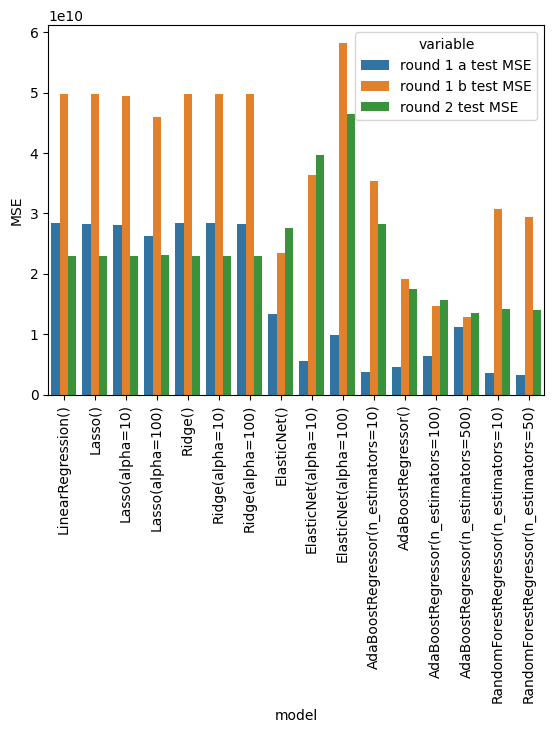

In [ ]:
ax = sns.barplot(pd.melt(results.drop([16, 17]).drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Looking at the models on the left side of the graph, we notice that many of the linear models (other than `ElasticNet` models), have relatively high MSE across all rounds. Therefore, we eliminate them and then plot the remaining models below.

[Text(0, 0, 'ElasticNet()'),
 Text(1, 0, 'ElasticNet(alpha=10)'),
 Text(2, 0, 'ElasticNet(alpha=100)'),
 Text(3, 0, 'AdaBoostRegressor(n_estimators=10)'),
 Text(4, 0, 'AdaBoostRegressor()'),
 Text(5, 0, 'AdaBoostRegressor(n_estimators=100)'),
 Text(6, 0, 'AdaBoostRegressor(n_estimators=500)'),
 Text(7, 0, 'RandomForestRegressor(n_estimators=10)'),
 Text(8, 0, 'RandomForestRegressor(n_estimators=50)')]

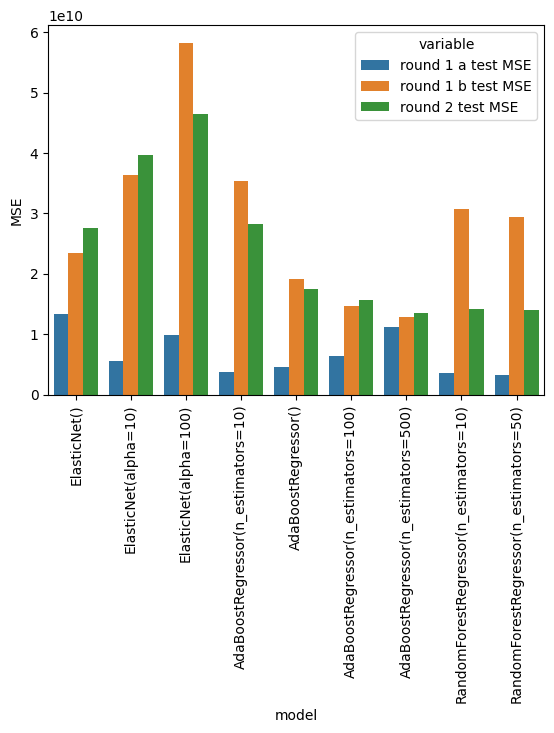

In [ ]:
ax = sns.barplot(pd.melt(results.drop([0, 1, 2,3, 4, 5,6, 16, 17]).drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

We can further eliminate `ElasticNet` with alpha of 1 and 100, as these do worse than `AdaBoostRegressor` across all test MSE.

[Text(0, 0, 'ElasticNet(alpha=10)'),
 Text(1, 0, 'AdaBoostRegressor(n_estimators=10)'),
 Text(2, 0, 'AdaBoostRegressor()'),
 Text(3, 0, 'AdaBoostRegressor(n_estimators=100)'),
 Text(4, 0, 'AdaBoostRegressor(n_estimators=500)'),
 Text(5, 0, 'RandomForestRegressor(n_estimators=10)'),
 Text(6, 0, 'RandomForestRegressor(n_estimators=50)')]

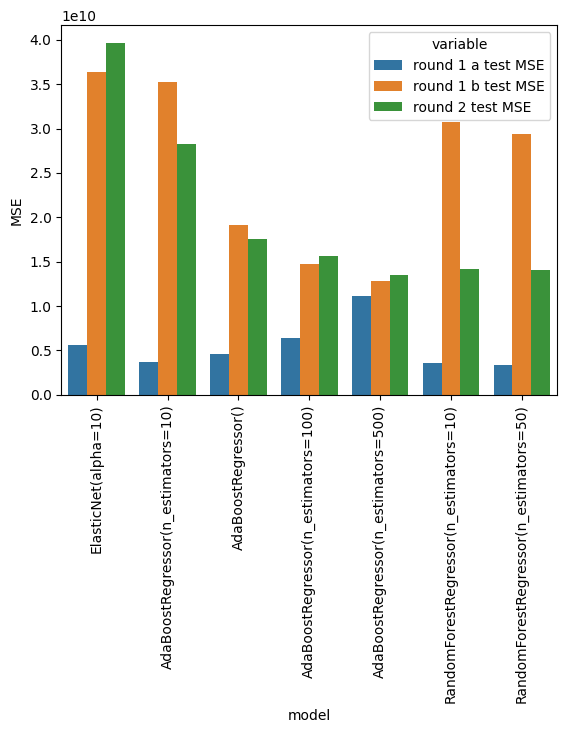

In [ ]:
ax = sns.barplot(pd.melt(results.drop([0, 1, 2,3, 4, 5,6,7,9, 16, 17]).drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

We can further eliminate ElasticNet alpha of 10, as it has higher MSE on all rounds the a number of the remaining models.

We can also eliminate adaboost with 10 estimators as it is has higher MSE on all rounds than random forest with 10 estimators.

[Text(0, 0, 'AdaBoostRegressor()'),
 Text(1, 0, 'AdaBoostRegressor(n_estimators=100)'),
 Text(2, 0, 'AdaBoostRegressor(n_estimators=500)'),
 Text(3, 0, 'RandomForestRegressor(n_estimators=10)'),
 Text(4, 0, 'RandomForestRegressor(n_estimators=50)')]

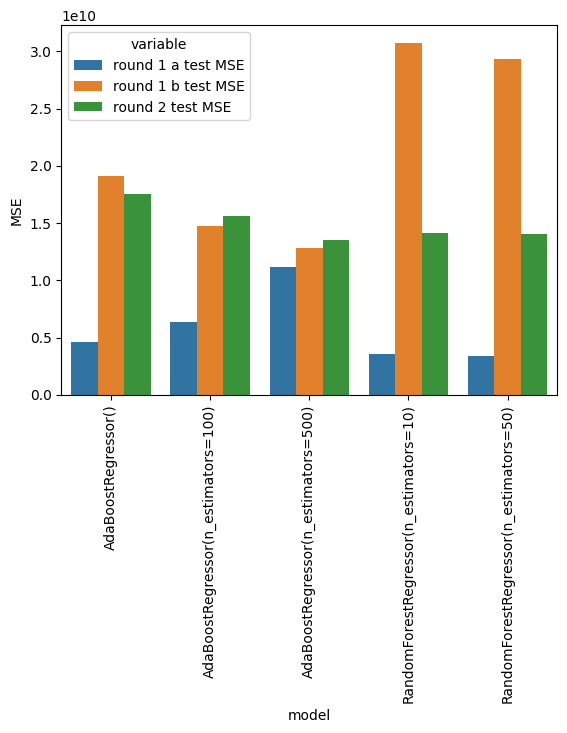

In [ ]:
ax = sns.barplot(pd.melt(results.drop([0, 1, 2,3, 4, 5,6,7,8, 9, 10, 16, 17]).drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

We are now down to just two types of models, adaboost and randomforest regression, which are very similiar models as they both use ensemble methods. Our randomforest regressors do better in short term prediction, but worse in long term prediction (as we can see using round 1 test b). Therefore which model we choose comes down to whether we want to do longer term or shorter term prediction. For longer term prediction we would choose the best RandomForest model which uses 50 estimaors. For shorter term prediction we would choose the best adaboost regressor which uses the default parameters of 50 estimators and a base estimator of DecisionTreeRegressor. It is interesting to note that our two best models are very similiar models, both using 50 estimators using ensembles of trees.

[Text(0, 0, 'AdaBoostRegressor()'),
 Text(1, 0, 'RandomForestRegressor(n_estimators=50)')]

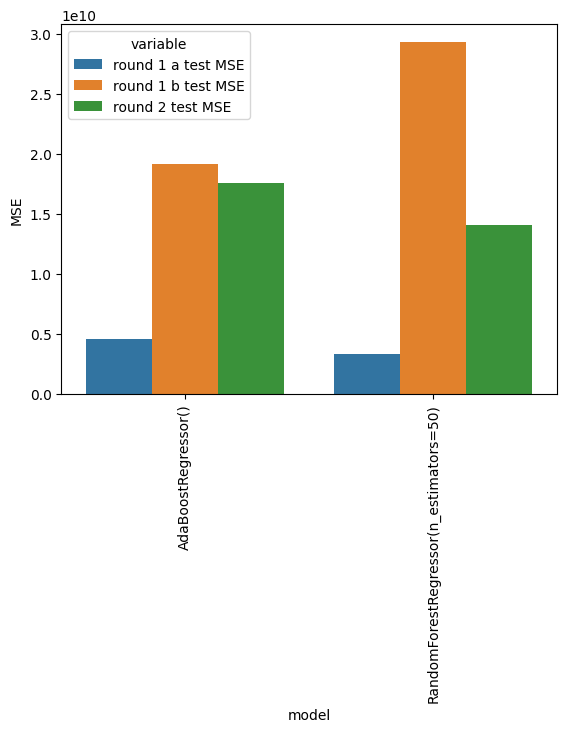

In [ ]:
ax = sns.barplot(pd.melt(results.drop([0, 1, 2,3, 4, 5,6,7,8, 9, 10, 12, 13, 14, 16, 17]).drop(["round 1 train MSE", "round 2 train MSE"], axis = 1),id_vars = "model").rename(columns = {"value": "MSE"}), x = "model", y = "MSE", hue = "variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# Conclusion

1. Retraining the model with newer data improves performance

  As hypothesized, the round 1 test b dataset had higher MSE than round 1 test a and round 2 data in the majority of models.

2. AutoML does not give better results than manually training and picking models
  
  We found that ensemble methods using trees as base estimators worked the best. The linear models did not do as well, probably due to non-linear relationships. The redshift automl and MLP did not do well, possibly due to overfitting.